In [97]:
import pandas as pd
import numpy as np
np.random.seed(seed=41)


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

import scipy.stats as st

import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.optim as optim

import keras
import tensorflow as tf

# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import os

## Load Data

In [120]:
# load kyc
df_kyc = pd.read_csv('kyc.csv')

# load cash
df_cash = pd.read_csv('cash_trxns.csv')

# load emt
df_emt = pd.read_csv('emt_trxns.csv')

# load wire
df_wire = pd.read_csv('wire_trxns.csv')

## Process KYC Data

Binarize gender column
<br>

One-hot_encode the Occupation column. Occupations are not ordinal, and so ordinal encoding would not be ideal.
<br>

Not including Name as this feature is not generalizable to unseen data. Same with cust_id.


In [121]:
# binarized gender
df_kyc.loc[(df_kyc.Gender)=='female', 'Gender'] = 0
df_kyc.loc[(df_kyc.Gender)=='male', 'Gender'] = 1
df_kyc.loc[(df_kyc.Gender)=='other', 'Gender'] = -1

# One-hot-encode Occupation
df_kyc = pd.get_dummies(df_kyc, prefix=['Occ'], columns=['Occupation'], dtype=int)

# # Ordinal-encode Occupation
# df_kyc['Occupation']= df_kyc['Occupation'].map(dict(zip(df_kyc['Occupation'].unique(), np.arange(len(df_kyc['Occupation'].unique())))))

## Process Cash Data

We can join the Cash dataframe to the KYC dataframe by customer id. <br>

In the Cash dataframe, we do not require trxn_id, as it is not useful for the classification task. <br>

The amount can be unified by sum. The sum might be more informative than average. As large/small sums <br> 
express information in the average, while averages might dampen the signal between extreme (really large and really small) amounts <br>

The type, we can count the number of deposits and number of withdrawals for each cust_id

In [122]:
# Process Type

# get number of deposts for each cust_id
df_cash_deposits = df_cash.loc[df_cash.type =='deposit'].groupby('cust_id').count()['type']
# merge with df_cash
df_cash = df_cash.merge(df_cash_deposits.rename('deposits'), how = 'left', left_on='cust_id', right_on='cust_id').fillna(0)


# get number of withdrawals for each cust_id
df_cash_withdrawals = df_cash.loc[df_cash.type =='withdrawal'].groupby('cust_id').count()['type']
# merge with df_cash
df_cash = df_cash.merge(df_cash_withdrawals.rename('withdrawals'), how = 'left', left_on='cust_id', right_on='cust_id').fillna(0)


# Process Amount

# get total sum of amounts 
df_cash_amounts = df_cash.groupby('cust_id')['amount'].sum()
df_cash = df_cash.merge(df_cash_amounts.rename('amount_cash'), how = 'left', left_on='cust_id', right_on='cust_id')

# drop duplicates
df_cash = df_cash.drop_duplicates('cust_id')

## Process EMT Data

We can add the emt data to the kyc dataset by customer id. <br>

We can get the the total amount recieved and total amount sent for each customer id.

In [123]:
# get total wire amount sent
df_amount_sent = df_emt.drop(columns=['emt message']).groupby('id sender').sum()['emt value']
# merge with df_emt
df_emt = df_emt.merge(df_amount_sent.rename('amount_emt_sent'), how = 'left', left_on='id sender', right_on='id sender').fillna(0)

# get total wire amount recieved
df_amount_received = df_emt.drop(columns=['emt message']).groupby('id receiver').sum()['emt value']
# merge with df_emt
df_emt = df_emt.merge(df_amount_received.rename('amount_emt_received'), how = 'left', left_on='id receiver', right_on='id receiver').fillna(0)

# get a message-sent flag
df_emt.loc[df_emt['emt message'] != 0, 'message_flag'] = 1
df_emt['message_flag'].fillna(0, inplace=True)
message_flag_dict  = dict(zip(df_emt['id sender'].unique(), 
                            df_emt[['id sender', 'message_flag']].groupby('id sender').sum()['message_flag']))

# drop duplicates
df_emt_sender = df_emt.drop_duplicates('id sender')
df_emt_receiver = df_emt.drop_duplicates('id receiver')

## Process Wire Data

We can add the wire data to the kyc dataset by customer id. <br>

We can get the the total amount recieved and total amount sent for each customer id.

In [124]:
# get total wire amount sent
df_amount_sent = df_wire.groupby('id sender').sum()['wire value']
# merge with df_wire
df_wire = df_wire.merge(df_amount_sent.rename('amount_wire_sent'), how = 'left', left_on='id sender', right_on='id sender').fillna(0)

# get total wire amount recieved
df_amount_received = df_wire.groupby('id receiver').sum()['wire value']
# merge with df_wire
df_wire = df_wire.merge(df_amount_received.rename('amount_wire_received'), how = 'left', left_on='id receiver', right_on='id receiver').fillna(0)

# # domestic transaction
# df_wire['domestic'] = 0
# df_wire.loc[(df_wire['country sender'] == 'CA') & (df_wire['country receiver'] == 'CA'), 
#             'domestic'] = 1
# # foregin outbound transaction
# df_wire['foreign_outbound'] = 0
# df_wire.loc[(df_wire['country sender'] == 'CA') & (df_wire['country receiver'] != 'CA'), 
#             'foreign_outbound'] = 1
# # foregin inbound transaction
# df_wire['foreign_inbound'] = 0
# df_wire.loc[(df_wire['country sender'] != 'CA') & (df_wire['country receiver'] == 'CA'), 
#             'foreign_inbound'] = 1
# # unkown transaction
# df_wire['unknown'] = 0
# df_wire.loc[(df_wire['country sender'].isnull()) | (df_wire['country receiver'].isnull()), 
#             'unknown'] = 1

# # Transaction Dictionaries
# sender_domestic_dict = dict(zip(df_wire[['id sender', 'domestic']].groupby('id sender').sum().index,
#                                 df_wire[['id sender', 'domestic']].groupby('id sender').sum()['domestic']))
# sender_foreign_dict = dict(zip(df_wire[['id sender', 'foreign_outbound']].groupby('id sender').sum().index,
#                                 df_wire[['id sender', 'foreign_outbound']].groupby('id sender').sum()['foreign_outbound']))
# sender_other_dict = dict(zip(df_wire[['id sender', 'unknown']].groupby('id sender').sum().index,
#                                 df_wire[['id sender', 'unknown']].groupby('id sender').sum()['unknown']))

# receiver_domestic_dict = dict(zip(df_wire[['id receiver', 'domestic']].groupby('id receiver').sum().index,
#                                 df_wire[['id receiver', 'domestic']].groupby('id receiver').sum()['domestic']))
# receiver_foreign_dict= dict(zip(df_wire[['id receiver', 'foreign_inbound']].groupby('id receiver').sum().index,
#                                 df_wire[['id receiver', 'foreign_inbound']].groupby('id receiver').sum()['foreign_inbound']))
# receiver_other_dict = dict(zip(df_wire[['id receiver', 'unknown']].groupby('id receiver').sum().index,
#                                 df_wire[['id receiver', 'unknown']].groupby('id receiver').sum()['unknown']))


# Country Dictionary
df_countries = pd.concat([df_wire[['id sender', 'country sender']].rename(columns = {'id sender': 'id', 'country sender': 'country'}) , 
                         df_wire[['id receiver', 'country receiver']].rename(columns = {'id receiver': 'id', 'country receiver': 'country'})])
df_countries.drop_duplicates(inplace=True)

country_dict = dict(zip(df_countries['id'], 
                            df_countries['country']))


# drop duplicates
df_wire_sender = df_wire.drop_duplicates('id sender')
df_wire_receiver = df_wire.drop_duplicates('id receiver')

## Merge Datasets

We can merge all the new features back to the kyc dataset on customer id. <br>

Empty values we can assign zero, as imputing the values will create erroneous data.

In [125]:
# merge df_cash with df_kyc
df_kyc=df_kyc.merge(df_cash[['cust_id','deposits','withdrawals','amount_cash']], how = 'outer', left_on='cust_id', right_on='cust_id')


# merge df_emt with df_kyc
df_kyc=df_kyc.merge(df_emt_sender[['id sender','amount_emt_sent']], how = 'left', left_on='cust_id', right_on='id sender')
df_kyc=df_kyc.merge(df_emt_receiver[['id receiver','amount_emt_received']], how = 'left', left_on='cust_id', right_on='id receiver')

# merge df_wire with df_kyc
df_kyc=df_kyc.merge(df_wire_sender[['id sender','amount_wire_sent']], how = 'left', left_on='cust_id', right_on='id sender')
df_kyc=df_kyc.merge(df_wire_receiver[['id receiver','amount_wire_received']], how = 'left', left_on='cust_id', right_on='id receiver')

# # add dictionaries
df_kyc['message_flag'] = df_kyc['cust_id'].map(message_flag_dict)
df_kyc['country'] = df_kyc['cust_id'].map(country_dict)
# df_kyc['sender_domestic'] = df_kyc['cust_id'].map(sender_domestic_dict).fillna(0)
# df_kyc['sender_foreign'] = df_kyc['cust_id'].map(sender_foreign_dict).fillna(0)
# # df_kyc['sender_other'] = df_kyc['cust_id'].map(sender_other_dict).fillna(0) # no others in kyc dataset
# df_kyc['receiver_domestic'] = df_kyc['cust_id'].map(receiver_domestic_dict).fillna(0)
# df_kyc['receiver_foreign'] = df_kyc['cust_id'].map(receiver_foreign_dict).fillna(0)
# # df_kyc['receiver_other'] = df_kyc['cust_id'].map(receiver_other_dict).fillna(0) # no others in kyc dataset

# one-hot-encode country
df_kyc = pd.get_dummies(df_kyc, prefix=['Country'], columns=['country'], dtype=int)

# remove Name and cust_id from dataframe
df_kyc.drop(columns=['Name', 'cust_id', 'id sender_x', 'id sender_y', 'id receiver_x', 'id receiver_y'], inplace=True)
df_kyc = df_kyc.fillna(0)

## Process Dataset

#### We can create a basic z-score outlier function

In [126]:
def detect_outliers_zscore(df, train_mean, train_std):
    df.reset_index(inplace=True, drop=True)
    outliers = np.where(((df - train_mean)/train_std) >= 3)
    # replaceo outliers with null values
    for o in outliers:
        df.iloc[o[0],o[1]] = np.nan
    
    # Fill null values with mean
    df = df.fillna(df.mean())
    return df

## Train-Test Split, Filter Outliers, Normalize Data

In [127]:
# Train-Test Split
df_train = df_kyc.iloc[:int(len(df_kyc)*0.75),:]
df_val = df_kyc.iloc[int(len(df_kyc)*0.75):int(len(df_kyc)*0.85),:]
df_test = df_kyc.iloc[int(len(df_kyc)*0.85):,:]

# remove outliers
df_train = detect_outliers_zscore(df_train, df_train.mean(), df_train.std())
df_val = detect_outliers_zscore(df_val, df_train.mean(), df_train.std())

# Split target and non-target on training data
df_train_non_target = df_train.loc[df_train.label == 0]
df_train_target = df_train.loc[df_train.label == 1]

# Standardize data
columns_to_scale = ['Age', 'Tenure','amount_cash', 'amount_emt_sent', 'deposits', 'withdrawals',
                    'amount_emt_received','amount_wire_sent','amount_wire_received',]
# columns_to_scale = ['Age', 'Tenure','amount_cash', 'amount_emt_sent', 'deposits', 'withdrawals',
#                     'amount_emt_received','amount_wire_sent','amount_wire_received', 'sender_domestic',
#                     'sender_foreign', 'receiver_domestic', 'receiver_foreign']

sc = StandardScaler()

# copy data
df_train_sc = df_train.copy()
df_val_sc = df_val.copy()
df_test_sc = df_test.copy()

# scale training set
scaled_train = sc.fit_transform(df_train[columns_to_scale])
df_train_sc[columns_to_scale] = scaled_train
# scale validation set
scaled_val = sc.transform(df_val[columns_to_scale])
df_val_sc[columns_to_scale] = scaled_val
# scale test set


# Split target and non-target on scaled training data
df_train_non_target_sc = df_train_sc.loc[df_train_sc.label == 0]
df_train_target_sc = df_train_sc.loc[df_train_sc.label == 1]

## Imbalance Investigation

In [129]:
df_kyc.label.value_counts()

print('There are', df_train.label.value_counts()[0], 'non-target lables in training')
print('There are', df_train.label.value_counts()[1], 'target lables in trianing')
print('There are', df_train.label.value_counts()[0]/df_train.label.value_counts()[1], 'times more non-target lables')

print('There are', df_val.label.value_counts()[0], 'non-target lables in validation')
print('There are', df_val.label.value_counts()[1], 'target lables in validation')
print('There are', df_val.label.value_counts()[0]/df_val.label.value_counts()[1], 'times more non-target lables')

There are 142714 non-target lables in training
There are 4127 target lables in trianing
There are 34.58056699781924 times more non-target lables
There are 19027 non-target lables in validation
There are 552 target lables in validation
There are 34.469202898550726 times more non-target lables


## Initial Approach

We can start with a random forest and see the effects of upsampling and downsampling on the performance. Random forest models are fairly intuitive and easy to tune if needed.

### Benchmark Downsampling

In [53]:
# Downsample minority class
df_kyc_majority_downsampled = resample(df_train_non_target_sc, 
                                 replace=True,     
                                 n_samples=len(df_train_target_sc))
df_downsampled = pd.concat([df_train_target_sc,df_kyc_majority_downsampled])

# shuffle dataset
df_downsampled = df_downsampled.sample(frac=1)

# get logistic regressor
# clf = LogisticRegression()
clf = RandomForestClassifier()

# define classifier
clf = clf.fit(df_downsampled.drop(columns=['label']), df_downsampled['label'])

# prediction dfs
df_kyc_val_X = df_val.drop(columns=['label'])
df_kyc_val_y = df_val['label']

# predict
predictions = clf.predict(df_kyc_val_X)

# report
print(classification_report(df_kyc_val_y,predictions))

              precision    recall  f1-score   support

           0       1.00      0.27      0.42     19027
           1       0.04      0.99      0.07       552

    accuracy                           0.29     19579
   macro avg       0.52      0.63      0.25     19579
weighted avg       0.97      0.29      0.41     19579



### Benchmark Upsampling

In [54]:
# Upsample minority class
df_kyc_minority_upsampled = resample(df_train_target_sc, 
                                 replace=True,     
                                 n_samples=len(df_train_non_target_sc))
df_upsampled = pd.concat([df_train_non_target_sc,df_kyc_minority_upsampled])

# shuffle dataset
df_upsampled = df_upsampled.sample(frac=1)

# get logistic regressor
# clf = LogisticRegression()
clf = RandomForestClassifier()

# define classifier
clf = clf.fit(df_upsampled.drop(columns=['label']), df_upsampled['label'])

# prediction dfs
df_kyc_val_X = df_val.drop(columns=['label'])
df_kyc_val_y = df_val['label']

# predict
predictions = clf.predict(df_kyc_val_X)

# report
print(classification_report(df_kyc_val_y,predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     19027
           1       0.50      0.23      0.32       552

    accuracy                           0.97     19579
   macro avg       0.74      0.61      0.65     19579
weighted avg       0.96      0.97      0.97     19579



## Custom Models

Let's define some custom models for further experimentation. These models will be composite models, containing multiple versions of themselves that can then be used in multi-voting.

#### Custom Logistic Regression

In [107]:
class MyLogistic(LogisticRegression):
    def __init__(self, number_of_models, penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                 intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', 
                 max_iter=500, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None):
        super().__init__(penalty=penalty, dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, 
                 intercept_scaling=intercept_scaling, class_weight=class_weight, random_state=random_state,
                 solver=solver, max_iter=max_iter, multi_class=multi_class, verbose=verbose, warm_start=warm_start,
                 n_jobs=n_jobs, l1_ratio=n_jobs)

        self.model = [LogisticRegression() for i in range(number_of_models)]
    
    def fit(self, sample_ids, df_kyc_train):

        # for each of the 31 modules, train each model
        for i, id in enumerate(sample_ids):
            df_train_X = df_kyc_train.loc[id].drop(columns=['label'])
            df_train_y = df_kyc_train.loc[id]['label']
            self.model[i] = self.model[i].fit(df_train_X,df_train_y)

        return self.model
    
    def predict(self, X):
        
        predictions = []

        # for each model, predict, and then take the majority
        preds = [self.model[i].predict(X) for i in range(len(self.model))]
        # stack arrays
        preds = np.vstack(preds)

        for i in range(preds.shape[1]):
            predictions.append(st.mode(preds[:,i])[0])

        return predictions

#### Custom Random Forest

In [108]:
class MyRandomForestClassifier(RandomForestClassifier):
    def __init__(self, number_of_models, n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                 max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                 n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, 
                 ccp_alpha=0.0, max_samples=None):
        super().__init__(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                         min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                         min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, 
                         max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, 
                         bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
                         verbose=verbose, warm_start=warm_start, class_weight=class_weight, 
                         ccp_alpha=ccp_alpha, max_samples=max_samples)

        self.model = [RandomForestClassifier() for _ in range(number_of_models)]
    
    def fit(self, cluster_ids, df_kyc_train):

        # for each of the 31 modules, train each model
        for i, id in enumerate(cluster_ids):
            df_train_X = df_kyc_train.loc[id].drop(columns=['label'])
            df_train_y = df_kyc_train.loc[id]['label']
            self.model[i] = self.model[i].fit(df_train_X,df_train_y)

        return self.model
    
    def predict(self, X):
        
        predictions = []

        # for each model, predict, and then take the majority
        preds = [self.model[i].predict(X) for i in range(len(self.model))]
        # stack arrays
        preds = np.vstack(preds)

        for i in range(preds.shape[1]):
            predictions.append(st.mode(preds[:,i])[0])

        return predictions

#### Custom Random Forest -- Minority Class Sensitive

In [109]:
class MyRandomForestClusterClassifier(RandomForestClassifier):
    def __init__(self, number_of_models, n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                 max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                 n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, 
                 ccp_alpha=0.0, max_samples=None):
        super().__init__(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                         min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                         min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, 
                         max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, 
                         bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
                         verbose=verbose, warm_start=warm_start, class_weight=class_weight, 
                         ccp_alpha=ccp_alpha, max_samples=max_samples)

        self.model = [RandomForestClassifier() for _ in range(number_of_models)]
    
    def fit(self, cluster_ids, df_kyc_train):

        # for each of the 31 modules, train each model
        for i, id in enumerate(cluster_ids):
            df_train_X = df_kyc_train.loc[id].drop(columns=['label'])
            df_train_y = df_kyc_train.loc[id]['label']
            self.model[i] = self.model[i].fit(df_train_X,df_train_y)

        return self.model
    
    def predict(self, X, threshold=0.5):
        
        '''
        Make classification one models predicts minority class
        This ensemble method is instead of voting, and is minority sensitive

        '''

        predictions = []

        # for each model, predict, and then take the majority
        preds = [self.model[i].predict_proba(X)[:,1] for i in range(len(self.model))] # only take minority class predictions

        # stack arrays
        preds = np.vstack(preds)

        for i in range(preds.shape[1]):
            if preds[:,i].any() >= threshold:
                value = 1
            else:
                value = 0
            predictions.append(value)

        return predictions

#### Custom MLP

In [110]:
# def my_f1_macro_metric(y_true, y_pred):
#     from sklearn.metrics import f1_score
#     # f1_score = f1_score(y_true, y_pred, average='macro')
#     metric = keras.metrics.F1Score(average='macro', threshold=None, 
#                                    name="f1_score", dtype=None)
#     # metric.update_state(y_true, y_pred)
    
#     # metric.result()
#     return  metric.update_state(y_true, y_pred)

In [111]:
def MyNeuralNetwork(input_shape):   
    # Deep stacked MLP with dropout
    model = keras.models.Sequential([
        keras.layers.Input(shape=input_shape),
        # keras.layers.Flatten(input_shape=input_shape),
        # keras.layers.Dense(1024, kernel_initializer='normal', activation='relu',
        #                    kernel_regularizer= keras.regularizers.L1L2(l1=0.01, l2=0.01)),
        # keras.layers.Dense(512, kernel_initializer='normal', activation='relu'),
        # keras.layers.Dropout(0.1),
        # keras.layers.Dense(256, kernel_initializer='normal', activation='relu',
        #                    kernel_regularizer= keras.regularizers.L1L2(l1=0.01, l2=0.01)),
        # keras.layers.Dropout(0.1),
        # keras.layers.Dense(128,kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(64,kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(32,kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer="adam",
        loss = keras.losses.BinaryCrossentropy() ,
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    return model

In [112]:
class MyNeuralNetworkClassifier():
    def __init__(self, number_of_models, input_shape):

        self.model = [MyNeuralNetwork(input_shape) for _ in range(number_of_models)]
    
    def fit(self, cluster_ids, df_kyc_train, epochs, batch_size):

        # for each of the 31 modules, train each model
        for i, id in enumerate(cluster_ids):
            df_train_X = df_kyc_train.loc[id].drop(columns=['label'])
            df_train_y = df_kyc_train.loc[id]['label']
            self.model[i].fit(df_train_X, df_train_y, epochs=epochs, batch_size=batch_size)
            
    
    def predict(self, X, threshold = 0.5):
        
        predictions = []

        # for each model, predict, and then take the majority
        preds = [self.model[i].predict(X).T for i in range(len(self.model))]

        # binarize predictions
        preds = [np.where(preds[i] <= threshold, 0 ,1) for i in range(len(preds))]

        # stack arrays
        preds = np.vstack(preds)

        for i in range(preds.shape[1]):

            predictions.append(st.mode(preds[:,i])[0])
        
        return predictions

We can make a variant of the network with early stopping for longer training runs

In [113]:
class EarlyStoppingByLossVal(keras.callbacks.Callback):
    def __init__(self, model, X_val, y_val):
        super(keras.callbacks.Callback, self).__init__()
        # self.monitor = monitor
        self.patience = 0
        self.best_f1 = 0
        self.X = X_val
        self.y = y_val
        self.model = model

    def on_epoch_end(self, epoch, logs={}): # need to pass epoch & logs because keras expects it
        from sklearn.metrics import f1_score
        y_pred = (self.model.predict(self.X).ravel()>0.5)+0 # need binary outputs for sklearn f1_score 

        current_f1 = f1_score(self.y, y_pred, average='macro')
        print('Validation Macro F1 Score', current_f1)

        if current_f1 > self.best_f1:
            # update best f1
            self.best_f1 = current_f1
            # reset patience
            self.patience = 0

        if self.patience == 2:
            print('Early Stopping')
            self.model.stop_training = True
        
        self.patience+=1


In [114]:
class MyNeuralNetworkClassifierEarlyStopping():
    def __init__(self, number_of_models, input_shape):

        self.model = [MyNeuralNetwork(input_shape) for _ in range(number_of_models)]
    
    def fit(self, cluster_ids, df_kyc_train, epochs, batch_size):

        # for each of the 31 modules, train each model
        for i, id in enumerate(cluster_ids):
            # Split Val-&-Train. Id's are already shuffled
            train_ids = id[:int(len(id)*0.85)]
            val_ids = id[int(len(id)*0.85):]
            df_train_X = df_kyc_train.loc[train_ids].drop(columns=['label'])
            df_train_y = df_kyc_train.loc[train_ids]['label']
            df_val_X = df_kyc_train.loc[val_ids].drop(columns=['label'])
            df_val_y = df_kyc_train.loc[val_ids]['label']

            callbacks = [EarlyStoppingByLossVal(self.model[i], df_val_X, df_val_y)]

            self.model[i].fit(df_train_X, df_train_y, epochs=epochs, 
                              batch_size=batch_size, 
                              validation_data= (df_val_X, df_val_y),
                              callbacks=callbacks)
            
    
    def predict(self, X, threshold = 0.5):
        
        predictions = []
        
        # switch to eval mode

        # for each model, predict, and then take the majority
        preds = [self.model[i].predict(X).T for i in range(len(self.model))]

        # binarize predictions
        preds = [np.where(preds[i] <= threshold, 0 ,1) for i in range(len(preds))]

        # stack arrays
        preds = np.vstack(preds)

        for i in range(preds.shape[1]):

            predictions.append(st.mode(preds[:,i])[0])
        
        return predictions

## Cluster-Based Resampling

Majority class is ~34x larger than minority class. We can divide the majority class into 34 distinct agglomerative clusters, using k-means clustering. We can then pair each cluster with the entire minority class dataset and train 34 random forest classifiers, ensembling them in a  multi-voting scheme.

In [54]:
# Define KMeans Algorithm
# Fit algorithm on majority class
kmeans = KMeans(n_clusters=34, random_state=0, n_init="auto", max_iter=50).fit(df_train_non_target_sc)

# For each cluster, concatenate with minority class

cluster_ids = []
for c in range(34):
    # Get Majority training dataset
    cluster_index = np.where(kmeans.labels_ == c)
    df_majority_cluster = df_train_non_target_sc.iloc[cluster_index]

    # Concatenate with minority dataset
    df_cluster_train = pd.concat([df_majority_cluster, df_train_target_sc])

    # Shuffle dataset
    df_cluster_train = df_cluster_train.sample(frac=1)

    # Store Ids
    cluster_ids.append(df_cluster_train.index)


# Train Custom Random Forest Model
resampling_model = MyRandomForestClassifier(34)

# Train Model
resampling_model.fit(cluster_ids, df_train_sc)

# predict
df_kyc_val_X = df_val_sc.drop(columns=['label'])
df_kyc_val_y = df_val_sc['label']

predictions = resampling_model.predict(df_kyc_val_X)

# print report
print(classification_report(df_kyc_val_y,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19027
           1       0.03      1.00      0.05       552

    accuracy                           0.03     19579
   macro avg       0.01      0.50      0.03     19579
weighted avg       0.00      0.03      0.00     19579



c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Resampling Investigation

### Investigate Number of Resampled Models to Use

Procedure:

Perform 123719 -choose-3543  n number of times, until the resampling error (sampling error formula) is reduced on Age and Tenure. This will give you 'n' models to train. This will ensure that the n resamplings accurately covers the 123719  non-target population statistics (on two dimensions, age and tenure)

For each model, give one random sample of 3543  from the non-target population, and the entire 3543  target population.

In [115]:
number_of_iterations = 34
sample_size = 3543 
total_sample_size = sample_size
sample_errors_age = []
sample_errors_tenure = []
sample_ids = []


# calculate Z-score on Age and Tenure (95 percentile)
# Z-score = (X - mu)/sigma
Z_age = (df_train_non_target.Age.quantile(0.95) - df_train_non_target.Age.mean())/df_train_non_target.Age.std()
Z_tenure = (df_train_non_target.Tenure.quantile(0.95) - df_train_non_target.Tenure.mean())/df_train_non_target.Tenure.std()


for _ in range(number_of_iterations):
    # get a random sample of non-target indexes
    sample = np.random.choice(len(df_train_non_target), sample_size, replace=False).tolist()
    sample_ids.append(sample)
    # update total sample size
    total_sample_size+=sample_size

    # calculate sample error
    # SE = Z * sigma/sqrt(sample_size)
    SE_age =  Z_age * df_train_non_target.Age.std() / np.sqrt(total_sample_size)
    SE_tenure =  Z_tenure * df_train_non_target.Tenure.std() / np.sqrt(total_sample_size)

    # store results
    sample_errors_age.append(SE_age)
    sample_errors_tenure.append(SE_tenure)

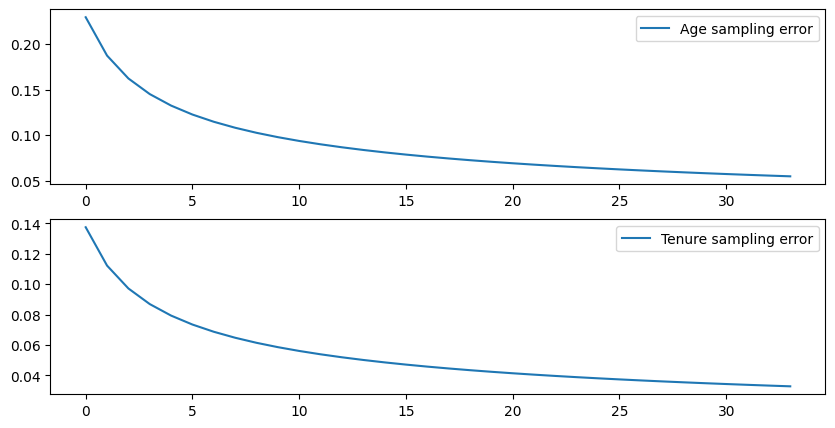

In [116]:
fig, axs = plt.subplots(2,1, figsize=(10,5))

axs[0].plot(range(len(sample_errors_age)), sample_errors_age, label = 'Age sampling error')
axs[1].plot(range(len(sample_errors_tenure)), sample_errors_tenure, label = 'Tenure sampling error')
axs[0].legend()
axs[1].legend()

plt.show()

We can use 31 independent models. We have the samples ids stored. Use these sample ids to get the non-target data, and join with entire target data. <br>
This will create 31 datasets of 3542 non-target and target records

In [117]:
# update sample ids
sample_ids = sample_ids[:-3]

# for each 31 non-target sample, add the target indexes
for i in range(len(sample_ids)):
    sample_ids[i].extend(df_train_target.index.to_list())
    # shuffle the data
    np.random.shuffle(sample_ids[i])

## Random Up-and-Downsampling 

In the benchmark case, upsampling seems to perform better than downsampling. <br>

Usample the minority class by a random amount (no greater than majority class) for a number k iterations. <br>
Then randomly downsample the majority class to the same size.

Batch these datasets together and use to train k models. Ensemble models and use multi-voting.

### Create Random Batches

In [118]:
# number of models
number_of_iterations = number_of_models = 31

# sample ids list
sample_ids = []

# size of class imbalance
class_imb = len(df_train_non_target_sc) - len(df_train_target_sc)

# get resampled data
for i in range(number_of_iterations):

    # random choice for upsampling (not larger than majority class)
    up_rnd = np.random.choice(class_imb, 1)[0]

    # update minority size
    minority_size = len(df_train_target) + up_rnd

    # upsample minority class
    df_kyc_minority_upsampled = resample(df_train_target_sc, 
                                    replace=True,     
                                    n_samples=minority_size)

    # downsample majority class
    df_kyc_majority_downsampled = resample(df_train_non_target_sc, 
                                    replace=True,     
                                    n_samples=minority_size)
    # join dataframes
    df_kyc_up_down = pd.concat([df_kyc_minority_upsampled,df_kyc_majority_downsampled])
    
    # shuffle dataframe
    df_kyc_up_down = df_kyc_up_down.sample(frac=1)

    # store index
    sample_ids.append(df_kyc_up_down.index)
    

### Recursive Feature Elimintation

In [94]:
# from sklearn.model_selection import cross_val_score, RepeatedKFold
# from sklearn.feature_selection import RFE
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline

# # define dataset
# df = pd.concat([df_train_sc,df_val_sc])

# # partition
# X = df.drop(columns=['label'])
# y = df['label']

# def get_models():
#     models = dict()
#     for i in range(20,50):
#         rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select = i)
#         model = DecisionTreeClassifier()
#         models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
#         return models

# def evaluate_model_f1(model, X,y):
#     cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
#     scores = cross_val_score(model, X, y, scoring = 'f1_macro', cv=cv, n_jobs=-1, error_score = 'raise', verbose = 2)

#     return scores, features

# # evaluate

# models = get_models()
# results_f1, names = list(), list()
# for name, model in models.items():
#     scores_f1, features = evaluate_model_f1(model, X,y)
#     results_f1.append(scores_f1)
#     print(f'>{name}, {np.mean(scores_f1)}')
#     print('Features Selected:', features)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 35.6min remaining: 23.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 36.2min finished


ValueError: too many values to unpack (expected 2)

In [96]:
# from sklearn.feature_selection import RFE
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import cross_val_score

# # define dataset
# df = pd.concat([df_train_sc,df_val_sc])

# # partition
# X = df.drop(columns=['label'])
# y = df['label']

# # model
# estimator = DecisionTreeClassifier()

# # RFE loop
# for i in range(20,50):
#     selector = RFE(estimator, n_features_to_select=i, step=1)
#     # selector = selector.fit(X, y)
#     scores = cross_val_score(estimator=selector, X=X, y=y, cv=5, n_jobs=4)
#     features = selector.get_feature_names_out()

#     print('Macro F1:', np.mean(scores))
#     print('Features:',features)


KeyboardInterrupt: 

#### Train & Evaluate Logistic Regression Model

In [67]:
# Initialize Model
resampling_model = MyLogistic(len(sample_ids))

# Train Model
resampling_model.fit(sample_ids, df_train_sc)

# predict
df_kyc_val_X = df_val_sc.drop(columns=['label'])
df_kyc_val_y = df_val_sc['label']

predictions = resampling_model.predict(df_kyc_val_X)

# print report
print(classification_report(df_kyc_val_y,predictions))

c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     19027
           1       0.24      0.87      0.37       552

    accuracy                           0.92     19579
   macro avg       0.62      0.90      0.66     19579
weighted avg       0.97      0.92      0.94     19579



#### Train & Evaluate Random Forest

In [93]:
# Initialize Model
resampling_model = MyRandomForestClassifier(31)

# Train Model
resampling_model.fit(sample_ids, df_train_sc)

# predict
df_kyc_val_X = df_val_sc.drop(columns=['label'])
df_kyc_val_y = df_val_sc['label']

predictions = resampling_model.predict(df_kyc_val_X)

# print report
print(classification_report(df_kyc_val_y,predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19027
           1       0.53      0.64      0.58       552

    accuracy                           0.97     19579
   macro avg       0.76      0.81      0.78     19579
weighted avg       0.98      0.97      0.98     19579



## Random Up-and-Downsampling with Neural Nets

### Feature Permutation Importance

There are 263 features, not all of them are likely important, many may also be colinear. 

We can use feature permutation importance to determine which features are the best predictors.

For every feature in the feature space, randomly permute it, so that it is loses its correspondence with the target and measure the decrease in performance. Permuted features with that cause the highest decrease in performance are more important.

#### Permutation Importance with three-layer neural network

In [141]:
from sklearn.metrics import f1_score
# partition datasets
X_train = df_train_sc.drop(columns=['label'])
y_train = df_train_sc['label']

X_val = df_val_sc.drop(columns=['label'])
y_val = df_val_sc['label']

# Train Model
model = MyNeuralNetwork(X_train.shape[1])

epochs = 1
batch = 128

# fit
keras.utils.set_random_seed(1337)
print('.....Calcualting Base f1 Score.....')
model.fit(X_train,y_train)
predictions = (model.predict(X_val).ravel()>0.5)+0
base_score = f1_score(y_val, predictions)
print('base f1 score:',base_score)


# Permuation loop
print('.....Starting Permuation Importance.....')
features = []
permutation_score =[]
for feature in X_train.columns:
    X_permute_train = X_train.copy()
    X_permute_train[feature] = X_permute_train[feature].sample(frac=1)
    # fit model
    model.fit(X_permute_train,y_train)
    # predict f1
    predictions = (model.predict(X_val).ravel()>0.5)+0
    score = f1_score(y_val, predictions)
    # performance decrease
    p_score = base_score - score
    print('Feature:',feature)
    print('Permuted f1 score:', score)
    print('performance decrease:',p_score)
    # append lists
    permutation_score.append(p_score)
    features.append(feature)

df_results = pd.DataFrame({'feature': features, 'performance_decrease': permutation_score})

.....Calcualting Base f1 Score.....
612/612 [==============================] - 1s 749us/step
base f1 score: 0.5814185814185815
.....Starting Permuation Importance.....
612/612 [==============================] - 1s 861us/step
Feature: Gender
Permuted f1 score: 0.5846153846153846
performance decrease: -0.003196803196803155
612/612 [==============================] - 0s 755us/step
Feature: Age
Permuted f1 score: 0.58098223615465
performance decrease: 0.00043634526393154793
612/612 [==============================] - 1s 938us/step
Feature: Tenure
Permuted f1 score: 0.5675392670157068
performance decrease: 0.01387931440287471
612/612 [==============================] - 0s 764us/step
Feature: Occ_Actor
Permuted f1 score: 0.5803108808290155
performance decrease: 0.0011077005895659964
612/612 [==============================] - 0s 758us/step
Feature: Occ_Actuary
Permuted f1 score: 0.5803757828810021
performance decrease: 0.0010427985375793813
612/612 [==============================] - 0s 775us/ste

<Axes: >

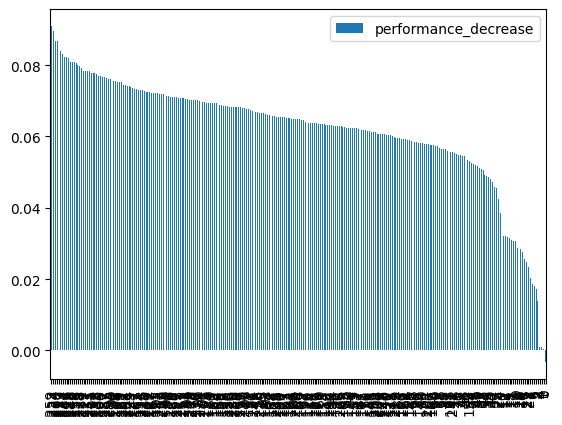

In [144]:
# df_results.plot(kind = 'bar')

df_results.sort_values(by = 'performance_decrease', ascending=False).plot(kind = 'bar')

#### Train & Evaluate Custom Neural Network without early stopping

In [119]:
input_shape = df_train_sc.drop(columns=['label']).shape[1]
epochs = 1
batch_size = 10


# Initialize Model
resampling_model = MyNeuralNetworkClassifier(number_of_models,input_shape)

# Train Model
resampling_model.fit(sample_ids, df_train_sc, epochs, batch_size)

# predict
df_kyc_val_X = df_val_sc.drop(columns=['label'])
df_kyc_val_y = df_val_sc['label']

predictions = resampling_model.predict(df_kyc_val_X, threshold = 0.95)

# print report
print(classification_report(df_kyc_val_y,predictions))

612/612 [==============================] - 1s 793us/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19027
           1       0.65      0.57      0.61       552

    accuracy                           0.98     19579
   macro avg       0.82      0.78      0.80     19579
weighted avg       0.98      0.98      0.98     19579



In [226]:
input_shape = df_train_sc.drop(columns=['label']).shape[1]
epochs = 1
batch_size = 10


# Initialize Model
resampling_model = MyNeuralNetworkClassifier(number_of_models,input_shape)

# Train Model
resampling_model.fit(sample_ids, df_train_sc, epochs, batch_size)

# predict
df_kyc_val_X = df_val_sc.drop(columns=['label'])
df_kyc_val_y = df_val_sc['label']

predictions = resampling_model.predict(df_kyc_val_X, threshold = 0.95)

# print report
print(classification_report(df_kyc_val_y,predictions))

612/612 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     19027
           1       0.62      0.45      0.52       552

    accuracy                           0.98     19579
   macro avg       0.80      0.72      0.75     19579
weighted avg       0.97      0.98      0.97     19579



#### Train & Evaluate Custom Neural Network with Early Stopping

In [82]:
input_shape = df_train_sc.drop(columns=['label']).shape[1]
epochs = 30
batch_size = 64


# Initialize Model
resampling_model = MyNeuralNetworkClassifierEarlyStopping(number_of_models,input_shape)

# Train Model
resampling_model.fit(sample_ids, df_train_sc, epochs, batch_size)

# predict
df_kyc_val_X = df_val_sc.drop(columns=['label'])
df_kyc_val_y = df_val_sc['label']

predictions = resampling_model.predict(df_kyc_val_X, threshold = 0.95)

# print report
print(classification_report(df_kyc_val_y,predictions))

Epoch 1/30
992/992 [==============================] - 2s 2ms/step
Validation Macro F1 Score 0.8807372895979294
2809/2809 [==============================] - 38s 13ms/step - loss: 2.7963 - binary_accuracy: 0.8727 - val_loss: 0.7991 - val_binary_accuracy: 0.8808
Epoch 2/30
992/992 [==============================] - 2s 2ms/step
Validation Macro F1 Score 0.9060136311380134
2809/2809 [==============================] - 36s 13ms/step - loss: 0.7726 - binary_accuracy: 0.8999 - val_loss: 0.7562 - val_binary_accuracy: 0.9060
Epoch 3/30
992/992 [==============================] - 2s 2ms/step
Validation Macro F1 Score 0.9051589627123946
2809/2809 [==============================] - 35s 13ms/step - loss: 0.7565 - binary_accuracy: 0.9046 - val_loss: 0.7521 - val_binary_accuracy: 0.9052
Epoch 4/30
992/992 [==============================] - 2s 2ms/step
Validation Macro F1 Score 0.9066456007003545
2809/2809 [==============================] - 36s 13ms/step - loss: 0.7537 - binary_accuracy: 0.9050 - val_los

#### Tuning Custom Neural Network

In [ ]:
input_shape = df_train_sc.drop(columns=['label']).shape[1]
epochs = 1
batch_size = 10


# Initialize Model
resampling_model = MyNeuralNetworkClassifier(number_of_models,input_shape)

# Train Model
resampling_model.fit(sample_ids, df_train_sc, epochs, batch_size)

# predict
df_kyc_val_X = df_val_sc.drop(columns=['label'])
df_kyc_val_y = df_val_sc['label']

predictions = resampling_model.predict(df_kyc_val_X, threshold = 0.95)

# print report
print(classification_report(df_kyc_val_y,predictions))